In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal, RandomUniform
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten, concatenate, Dropout, Lambda, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.metrics import Accuracy 


2022-12-19 19:31:10.207053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 19:31:10.431814: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-19 19:31:10.470711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 19:31:10.470729: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import neptune.new as neptune
import os
myProject = 'aligator/RNNN'
project = neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),
                        project=myProject) 
project.stop()



/tmp/ipykernel_5241/525511626.py:4: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  project = neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),


https://app.neptune.ai/aligator/RNNN/e/RNNN-26


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aligator/RNNN/e/RNNN-26


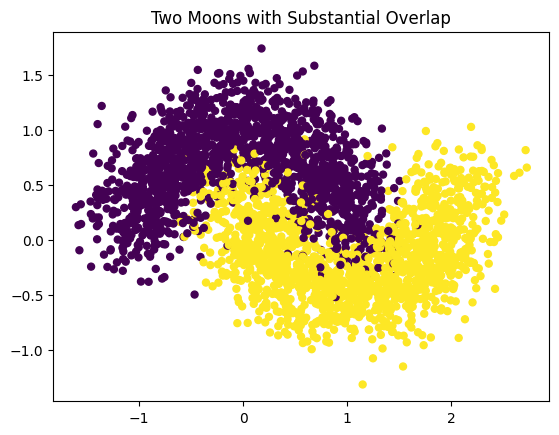

In [3]:
tf.random.set_seed(42)
np.random.seed(42) 
CUR_SEED = 42


plt.title('Two Moons with Substantial Overlap')
X, y = make_moons(n_samples=3000, shuffle=True , noise=0.25, random_state=1234)

plt.scatter(X[:, 0], X[:, 1], c=y, s=25)    
plt.show()

In [4]:
batch_size, n_epochs = 32, 100

In [5]:
def getBatchGradWgts(grads, wgts, lossVal, 
                      gradHist, lossHist, wgtsHist, 
                      recordWeight=True, npt_exp=None):
    dataGrad, dataWeight = {}, {}
    
    for wgt, grad in zip(wgts, grads):
        if '/kernel:' not in wgt.name:
            continue 
        layerName = wgt.name.split("/")[0]         
        dataGrad[layerName] = grad.numpy()
        dataWeight[layerName] = wgt.numpy()
        ## Log in Neptune
        if npt_exp:
            npt_exp[f'MeanGrads{layerName.upper()}'].log(np.mean(grad.numpy()))   
            npt_exp[f'MeanWgtBatch{layerName.upper()}'].log(np.mean(wgt.numpy()))         
        
    gradHist.append(dataGrad)
    lossHist.append(lossVal.numpy())
    if recordWeight:
        wgtsHist.append(dataWeight)           
                
                
def fitModel(X, y, model, optimizer, 
              n_epochs=n_epochs, curBatch_size=batch_size, 
              modelType = 'binary', ## regression
              npt_exp=None):
    
    if modelType == 'binary':
        lossFunc = tf.keras.losses.BinaryCrossentropy()
    elif modelType == 'regression':
        lossFunc = tf.keras.losses.MeanSquaredError()
        
    subData = tf.data.Dataset.from_tensor_slices((X, y))
    subData = subData.shuffle(buffer_size=42).batch(curBatch_size)
   
    gradHist, lossHist, wgtsHist = [], [], []                    
    
    for epoch in range(n_epochs):
        print(f'== Starting epoch {epoch} ==')        
        for step, (x_batch, y_batch) in enumerate(subData):
            with tf.GradientTape() as tape:
                yPred = model(x_batch, training=True)
                lossVal = lossFunc(y_batch, yPred)
                
            grads = tape.gradient(lossVal, model.trainable_weights)
            wgts = model.trainable_weights
            optimizer.apply_gradients(zip(grads, model.trainable_weights))           
            
            if step == 5:
                getBatchGradWgts(gradHist=gradHist, lossHist=lossHist, wgtsHist=wgtsHist, 
                                  grads=grads, wgts=wgts, lossVal=lossVal, npt_exp=npt_exp) 
                if npt_exp:
                    npt_exp['BatchLoss'].log(lossVal)   
                    
    getBatchGradWgts(gradHist=gradHist, lossHist=lossHist, wgtsHist=wgtsHist, 
                      grads=grads, wgts=wgts, lossVal=lossVal, npt_exp=npt_exp)    
    return gradHist, lossHist, wgtsHist



def gradientsVis(curGradHist, curLossHist, modelName):    
    fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(7,5))
    ax.set_title(f"Mean gradient {modelName}")
    for layer in curGradHist[0]:
        ax.plot(range(len(curGradHist)), [gradList[layer].mean() for gradList in curGradHist], label=f'Layer_{layer.upper()}')
    ax.legend()
    return fig


https://app.neptune.ai/aligator/RNNN/e/RNNN-27
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
== Starting epoch 0 ==


2022-12-19 19:31:21.415975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-19 19:31:21.416244: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 19:31:21.416267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archlinux): /proc/driver/nvidia/version does not exist
2022-12-19 19:31:21.419793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/aligator/.local/lib/python3.10/site-packages/ker

== Starting epoch 1 ==
== Starting epoch 2 ==
== Starting epoch 3 ==
== Starting epoch 4 ==
== Starting epoch 5 ==
== Starting epoch 6 ==
== Starting epoch 7 ==
== Starting epoch 8 ==
== Starting epoch 9 ==
== Starting epoch 10 ==
== Starting epoch 11 ==
== Starting epoch 12 ==
== Starting epoch 13 ==
== Starting epoch 14 ==
== Starting epoch 15 ==
== Starting epoch 16 ==
== Starting epoch 17 ==
== Starting epoch 18 ==
== Starting epoch 19 ==
== Starting epoch 20 ==
== Starting epoch 21 ==
== Starting epoch 22 ==
== Starting epoch 23 ==
== Starting epoch 24 ==
== Starting epoch 25 ==
== Starting epoch 26 ==
== Starting epoch 27 ==
== Starting epoch 28 ==
== Starting epoch 29 ==
== Starting epoch 30 ==
== Starting epoch 31 ==
== Starting epoch 32 ==
== Starting epoch 33 ==
== Starting epoch 34 ==
== Starting epoch 35 ==
== Starting epoch 36 ==
== Starting epoch 37 ==
== Starting epoch 38 ==
== Starting epoch 39 ==
== Starting epoch 40 ==
== Starting epoch 41 ==
== Starting epoch 42 ==
=

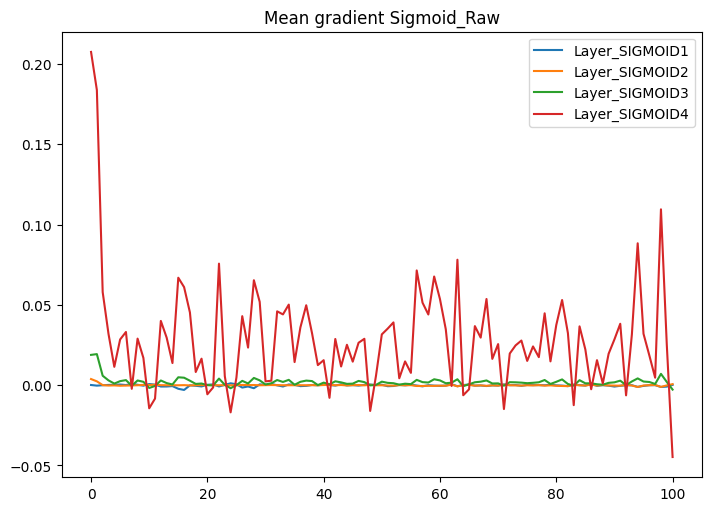

In [6]:
MODELNAME = 'vanSigBaseline'
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if MODELNAME == 'vanSigBaseline':    
    npt_exp = neptune.init(    
        api_token=os.getenv('NEPTUNE_API_TOKEN'),
        project=myProject, 
        name='VanishingGradSigmoid', 
        description='Vanishing Gradients with Sigmoid Activation Function', 
        tags=['vanishingGradients', 'sigmoid', 'neptune']) 
    
    ## Define Neptune callback 
    neptune_cbk = NeptuneCallback(run=npt_exp, base_namespace='metrics')
    def binaryModel(curName, curInitializer, curActivation, x_tr=None):
        model = Sequential()
        model.add(InputLayer(input_shape=(2, ), name=curName+"0"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"1"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"2"))
        model.add(Dense(5, kernel_initializer=curInitializer, activation=curActivation,  name=curName+"3"))
        model.add(Dense(1, kernel_initializer=curInitializer, activation='sigmoid', name=curName+"4"))
        return model 
    
    curOptimizer = tf.keras.optimizers.RMSprop()
    optimizer = curOptimizer
    curInitializer = RandomUniform(-1, 1)
    ## Compile the model
    model = binaryModel(curName="SIGMOID", curInitializer=curInitializer, curActivation="sigmoid")  
    model.compile(optimizer=curOptimizer, loss='binary_crossentropy', metrics=['accuracy'])
    ## Train and Log in Neptune    
    curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer, npt_exp=npt_exp)
    ## log in the plot comparing all layers
    npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, 
                                                                                    modelName='Sigmoid_Raw')))
    npt_exp.stop()  

elif MODELNAME == 'vanRelu':
    npt_exp = neptune.init(    
    api_token=os.getenv('NEPTUNE_API_TOKEN'),
    project=myProject, 
    name='VanishingGradRelu', 
    # description='Vanishing Gradients with Sigmoid Activation Function', 
    tags=['vanishingGradients', 'relu', 'neptune']) 

    def binaryModel(curName, curInitializer, curActivation, x_tr=None):
        model = Sequential()
        model.add(InputLayer(input_shape=(2, ), name=curName+"0"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"1"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"2"))
        model.add(Dense(5, kernel_initializer=curInitializer, activation=curActivation,  name=curName+"3"))
        model.add(Dense(1, kernel_initializer=curInitializer, activation='sigmoid', name=curName+"4"))
        return model 
    
    curOptimizer = tf.keras.optimizers.RMSprop()
    optimizer = curOptimizer
    curInitializer = RandomUniform(-1, 1)
    ## Compile the model
    model = binaryModel(curName="Relu", curInitializer=curInitializer, curActivation="relu")  
    model.compile(optimizer=curOptimizer, loss='binary_crossentropy', metrics=['accuracy'])
    ## Train and Log in Neptune    
    curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer, npt_exp=npt_exp)
    ## log in the plot comparing all layers
    npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, modelName='Relu')))
    npt_exp.stop() 
    
elif MODELNAME == 'vanSigSmall':
    npt_exp = neptune.init(    
    api_token=os.getenv('NEPTUNE_API_TOKEN'),
    project=myProject, 
    name='VanishingGradSigmoidSmall', 
    tags=['vanishingGradients', 'sigmoid', 'smallStructure', 'neptune']) 
    
    def binaryModel(curName, curInitializer, curActivation, x_tr=None):
        model = Sequential()      
        model.add(InputLayer(input_shape=(2, ), name=curName+"0"))
        model.add(Dense(3, kernel_initializer=curInitializer, activation=curActivation,  name=curName+"3"))
        model.add(Dense(1, kernel_initializer=curInitializer, activation='sigmoid', name=curName+"4"))
        return model 

    curOptimizer = tf.keras.optimizers.RMSprop()
    optimizer = curOptimizer
    curInitializer = RandomUniform(-1, 1)
    ## Compile the model
    model = binaryModel(curName="SIGMOID", curInitializer=curInitializer, curActivation="sigmoid")  
    model.compile(optimizer=curOptimizer, loss='binary_crossentropy', metrics=['accuracy'])
    ## Train and Log in Neptune    
    curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer, npt_exp=npt_exp)
    ## log in the plot comparing all layers
    npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, modelName='Sigmoid_Small')))
    npt_exp.stop()  

elif MODELNAME == 'vanBN':
    npt_exp = neptune.init(    
    api_token=os.getenv('NEPTUNE_API_TOKEN'),
    project=myProject, 
    name='VanishingGradBatchNorm', 
    tags=['vanishingGradients', 'relu', 'batchNormalization', 'neptune'])
    
    def binaryModel(curName, curInitializer, curActivation, x_tr=None):
        model = Sequential()      
        model.add(InputLayer(input_shape=(2, ), name=curName+"0"))
        model.add(BatchNormalization())
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"1"))  
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"2"))        
        # model.add(BatchNormalization())
        model.add(Dense(5, kernel_initializer=curInitializer, activation=curActivation, name=curName+"3"))
        model.add(Dense(1, kernel_initializer=curInitializer, activation=curActivation, name=curName+"4"))
        return model
    curOptimizer = tf.keras.optimizers.RMSprop()
    optimizer = curOptimizer
    curInitializer = RandomUniform(-1, 1)
    model = binaryModel(curName="SIGMOID", curInitializer=curInitializer, curActivation="sigmoid")  
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    ## Train and Log in Neptune    
    curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer, npt_exp=npt_exp)
    ## log in the plot comparing all layers
    npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, 
                                                                                    modelName='Sigmoid_BN')))
    npt_exp.stop()  
    
elif MODELNAME == 'vanSigWgtInit':
    npt_exp = neptune.init(    
        api_token=os.getenv('NEPTUNE_API_TOKEN'),
        project=myProject, 
        name='VanishingGradSigmoidWgtInit2', 
        tags=['vanishingGradients', 'sigmoid', 'weightInit2', 'neptune']) 
    
    ## Define Neptune callback 
    neptune_cbk = NeptuneCallback(run=npt_exp, base_namespace='metrics')
    def binaryModel(curName, curInitializer, curActivation, x_tr=None):
        model = Sequential()
        model.add(InputLayer(input_shape=(2, ), name=curName+"0"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"1"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"2"))
        model.add(Dense(5, kernel_initializer=curInitializer, activation=curActivation,  name=curName+"3"))
        model.add(Dense(1, kernel_initializer=curInitializer, activation='sigmoid', name=curName+"4"))
        return model 
    
    curOptimizer = tf.keras.optimizers.RMSprop()
    optimizer = curOptimizer

    curInitializer = 'glorot_uniform'  
    ## Compile the model
    model = binaryModel(curName="SIGMOID", curInitializer=curInitializer, curActivation="sigmoid") ## sigmoid  
    model.compile(optimizer=curOptimizer, loss='binary_crossentropy', metrics=['accuracy'])
    curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer, npt_exp=npt_exp)
    print("Final Accuracy", accuracy_score(y, (model(X) > 0.5)))
    ## log in the plot comparing all layers
    npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, 
                                                                                    modelName='Sigmoid_NormalWeightInit')))
    npt_exp.stop()  

elif MODELNAME == 'vanSigLR':
    npt_exp = neptune.init(    
        api_token=os.getenv('NEPTUNE_API_TOKEN'),
        project=myProject, 
        name='VanishingGradSigmoidLR2', 
        tags=['vanishingGradients', 'sigmoid', 'lr2', 'neptune'])
    
    def binaryModel(curName, curInitializer, curActivation, x_tr=None):
        model = Sequential()
        model.add(InputLayer(input_shape=(2, ), name=curName+"0"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"1"))
        model.add(Dense(10, kernel_initializer=curInitializer, activation=curActivation, name=curName+"2"))
        model.add(Dense(5, kernel_initializer=curInitializer, activation=curActivation,  name=curName+"3"))
        model.add(Dense(1, kernel_initializer=curInitializer, activation='sigmoid', name=curName+"4"))
        return model 
    
    curOptimizer = keras.optimizers.Adam(learning_rate=0.008) ## reduce the learning rate!
    curInitializer = RandomUniform(-1, 1)
    ## Compile the model
    model = binaryModel(curName="SIGMOID", curInitializer=curInitializer, curActivation="sigmoid")  
    model.compile(optimizer=curOptimizer, loss='binary_crossentropy', metrics=['accuracy'])
    ## Train and Log in Neptune    
    curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer, npt_exp=npt_exp)
    ## log in the plot comparing all layers
    npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, modelName='Sigmoid_Raw')))
    npt_exp.stop()  
    

https://app.neptune.ai/aligator/RNNN/e/RNNN-28
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
== Starting epoch 0 ==
== Starting epoch 1 ==
== Starting epoch 2 ==
== Starting epoch 3 ==
== Starting epoch 4 ==
== Starting epoch 5 ==
== Starting epoch 6 ==
== Starting epoch 7 ==
== Starting epoch 8 ==
== Starting epoch 9 ==
== Starting epoch 10 ==
== Starting epoch 11 ==
== Starting epoch 12 ==
== Starting epoch 13 ==
== Starting epoch 14 ==
== Starting epoch 15 ==
== Starting epoch 16 ==
== Starting epoch 17 ==
== Starting epoch 18 ==
== Starting epoch 19 ==
== Starting epoch 20 ==
== Starting epoch 21 ==
== Starting epoch 22 ==
== Starting epoch 23 ==
== Starting epoch 24 ==
== Starting epoch 25 ==
== Starting epoch 26 ==
== Starting epoch 27 ==
== Starting epoch 28 ==
== Starting epoch 29 ==
== Starting epoch 30 ==
== Starting 

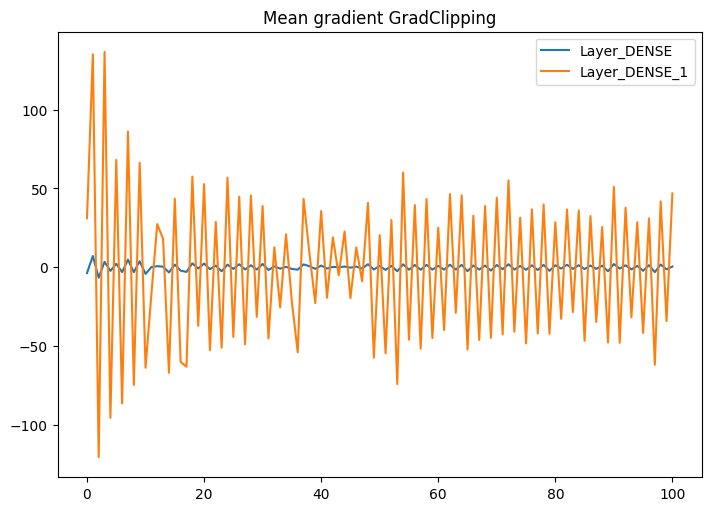

In [7]:
from sklearn.datasets import make_regression
from keras import regularizers
from tensorflow.keras.models import Model


MODELNAME = 'expGradClip'


if MODELNAME == 'expReluBaseline':    
    ### (1) change weight initi; 2) L2 norm; 3) gradients clipping
    npt_exp = neptune.init(    
            api_token=os.getenv('NEPTUNE_API_TOKEN'),
            project=myProject, 
            name='ExplodingGradRelu', 
            tags=['explodingGradients', 'relu', 'neptune'])
    
elif MODELNAME == 'expGlorotInit':
    npt_exp = neptune.init(    
            api_token=os.getenv('NEPTUNE_API_TOKEN'),
            project=myProject, 
            name='ExplodingGradGlorot', 
            tags=['explodingGradients', 'glorot', 'neptune'])
    
elif MODELNAME == 'expL2Reg':    
    npt_exp = neptune.init(    
            api_token=os.getenv('NEPTUNE_API_TOKEN'),
            project=myProject, 
            name='ExplodingGradL2Reg', 
            tags=['explodingGradients', 'l2 reg', 'neptune'])
    
elif MODELNAME == 'expGradClip':
    npt_exp = neptune.init(    
            api_token=os.getenv('NEPTUNE_API_TOKEN'),
            project=myProject, 
            name='ExplodingGradClip', 
            tags=['explodingGradients', 'gradients', 'clipping', 'neptune'])

# Generate regression dataset
nfeatures = 15
X, y = make_regression(n_samples=1500, n_features=nfeatures, noise=0.2, random_state=42)

# Define the regression model 
def regressionModel(X, y, curInitializer, USE_L2REG, secondLayerAct='relu'):  
    ## Construct the neural nets
    inp = Input(shape = (X.shape[1],)) 
    if USE_L2REG:
        ## need to change activation function as well
        x = Dense(35, activation='tanh', kernel_initializer=curInitializer, 
                  kernel_regularizer=regularizers.l2(0.01),
                  activity_regularizer=regularizers.l2(0.01))(inp)  
    else:
        x = Dense(35, activation=secondLayerAct, kernel_initializer=curInitializer)(inp)  
        
    out = Dense(1, activation='linear')(x)
    model = Model(inp, out)
    return model      
    
if MODELNAME == 'expReluBaseline': 
    sgd = tf.keras.optimizers.SGD()
    curOptimizer = sgd
    
    #### ! Uniform init 
    curInitializer = RandomUniform(4,5) 
    
    model = regressionModel(X, y, curInitializer, USE_L2REG=False)
    model.compile(loss='mean_squared_error', optimizer=curOptimizer, metrics=['mse'])
    
    curModelName = 'Relu_Raw'
    
elif MODELNAME == 'expGlorotInit':
    sgd = tf.keras.optimizers.SGD()
    curOptimizer = sgd
    
    #### ! Glorot init 
    curInitializer = 'glorot_normal'
    # curInitializer = 'glorot_uniform'
    
    model = regressionModel(X, y, curInitializer, USE_L2REG=False, secondLayerAct='tanh')
    model.compile(loss='mean_squared_error', optimizer=curOptimizer, metrics=['mse'])
    
    curModelName = 'GlorotInit'
    
elif MODELNAME == 'expL2Reg':
    sgd = tf.keras.optimizers.SGD()
    curOptimizer = sgd
    
    #### ! glorot init + L2 Reg
    # curInitializer = RandomUniform(4,5) 
    curInitializer = 'glorot_normal'
    model = regressionModel(X, y, curInitializer, USE_L2REG=True)
    model.compile(loss='mean_squared_error', optimizer=curOptimizer, metrics=['mse'])
    
    curModelName = 'L2Reg'
    
elif MODELNAME == 'expGradClip':    
    #### !Gradients clipping
    # sgd = tf.keras.optimizers.SGD(clipnorm=1.0)
    sgd = tf.keras.optimizers.SGD(clipvalue=50)

    curOptimizer = sgd
    
    #### ! Glorot init + L2 Reg
    # curInitializer = RandomUniform(4,5) 
    curInitializer = 'glorot_normal'

    model = regressionModel(X, y, curInitializer, USE_L2REG=False)
    model.compile(loss='mean_squared_error', optimizer=curOptimizer, metrics=['mse'])
    curModelName = 'GradClipping'    
    
## Train and Log in Neptune    
curGradHist, curLossHist, curWgtHist = fitModel(X, y, model, optimizer=curOptimizer,
                                                modelType = 'regression',
                                                npt_exp=npt_exp)

npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, 
                                                                                modelName=curModelName)))
npt_exp.stop()  




